# League of Legends - Win Probability Predictor using Sklearn and PyCaret

## Background
League of Legends is a multiplayer online battle arena video game in which 2 teams (red and blue) of 5 players face off.  
The main objective of the game is to destroy the opponent's base before they can destroy yours. Draws are inherently impossible.

## Motivation
An average League of Legends match lasts between 30 and 40 minutes, and goes through 3 arbitrary stages: early game, mid game and late game.  
I believe that the early game is a strong enough indicator of each team's chances of success, despite it only lasting for the first 10-14 minutes of the match.  
Therefore, this Jupyter Notebook aims to do the following:
1. Explore the dataset to discover some basic trends of a LoL game
2. Build a Machine Learning model to determine a team's probability of winning using only early game data
3. Compare different ML models to see which performs the best as a classifier for this task

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn import metrics
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
from pycaret.classification import *

## Dataset
This data set from [Kaggle](https://www.kaggle.com/datasets/gyejr95/league-of-legends-challenger-rank-game10min15min?select=Challenger_Ranked_Games_15minute.csv) contains the game stats at the 10 minute mark from over 26,000 ranked Challenger games (the highest skill level) in 2020. As the core gameplay of League of Legends has not changed drastically since then, I believe that the data is still relevant for this experiment.

In [2]:
df = pd.read_csv("./data/Challenger_Ranked_Games_10minute.csv")
df.head()

,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueFirstTowerLane,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragnoType,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragnoType,redDragon,redRiftHeralds
0,4247263043,0,14870,2889,32,6.4,199,53,0,3,9,7,19,2,0,0,[],0,0,0,0,0,0,[],0,0,1,18397,3297,36,7.2,229,32,0,9,3,22,17,8,0,0,[],0,0,0,0,0,1,['WATER_DRAGON'],1,0
1,4247155821,1,14497,2617,33,6.6,229,44,0,2,3,2,17,1,0,0,[],0,0,0,0,0,0,[],0,1,0,15893,4778,36,7.2,234,57,0,3,2,2,15,5,0,0,[],0,0,0,0,0,0,[],0,0
2,4243963257,0,15617,1757,34,6.8,223,39,0,3,11,4,15,6,0,0,[],0,0,0,0,0,0,[],0,0,1,20409,4324,37,7.4,236,45,0,11,3,11,21,4,1,0,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1
3,4241678498,0,15684,1439,35,7.0,251,64,0,3,4,2,62,4,0,0,[],0,0,0,0,0,0,[],0,0,1,16150,3633,35,7.0,256,48,0,4,3,5,12,7,0,0,[],0,0,0,0,0,0,[],0,0
4,4241538868,1,17472,3512,35,7.0,257,46,0,7,5,6,17,6,0,0,[],0,0,0,0,0,0,[],0,1,0,15588,3323,34,6.8,194,56,0,5,7,7,20,3,0,0,[],0,0,0,0,0,0,[],0,0


## Preprocessing the data

In [3]:
# Checking for missing values
df.isnull().sum()

gameId                        0
blueWins                      0
blueTotalGolds                0
blueCurrentGolds              0
blueTotalLevel                0
blueAvgLevel                  0
blueTotalMinionKills          0
blueTotalJungleMinionKills    0
blueFirstBlood                0
blueKill                      0
blueDeath                     0
blueAssist                    0
blueWardPlaced                0
blueWardKills                 0
blueFirstTower                0
blueFirstInhibitor            0
blueFirstTowerLane            0
blueTowerKills                0
blueMidTowerKills             0
blueTopTowerKills             0
blueBotTowerKills             0
blueInhibitor                 0
blueFirstDragon               0
blueDragnoType                0
blueDragon                    0
blueRiftHeralds               0
redWins                       0
redTotalGolds                 0
redCurrentGolds               0
redTotalLevel                 0
redAvgLevel                   0
redTotal

In [4]:
# Removing duplicate entries
print("Rows before: ", df.shape[0])
df = df.drop_duplicates(subset=['gameId'], keep='last')
print("Rows after: ", df.shape[0])
df

Rows before:  26409
Rows after:  26354


,gameId,blueWins,blueTotalGolds,blueCurrentGolds,blueTotalLevel,blueAvgLevel,blueTotalMinionKills,blueTotalJungleMinionKills,blueFirstBlood,blueKill,blueDeath,blueAssist,blueWardPlaced,blueWardKills,blueFirstTower,blueFirstInhibitor,blueFirstTowerLane,blueTowerKills,blueMidTowerKills,blueTopTowerKills,blueBotTowerKills,blueInhibitor,blueFirstDragon,blueDragnoType,blueDragon,blueRiftHeralds,redWins,redTotalGolds,redCurrentGolds,redTotalLevel,redAvgLevel,redTotalMinionKills,redTotalJungleMinionKills,redFirstBlood,redKill,redDeath,redAssist,redWardPlaced,redWardKills,redFirstTower,redFirstInhibitor,redFirstTowerLane,redTowerKills,redMidTowerKills,redTopTowerKills,redBotTowerKills,redInhibitor,redFirstDragon,redDragnoType,redDragon,redRiftHeralds
0,4247263043,0,14870,2889,32,6.4,199,53,0,3,9,7,19,2,0,0,[],0,0,0,0,0,0,[],0,0,1,18397,3297,36,7.2,229,32,0,9,3,22,17,8,0,0,[],0,0,0,0,0,1,['WATER_DRAGON'],1,0
1,4247155821,1,14497,2617,33,6.6,229,44,0,2,3,2,17,1,0,0,[],0,0,0,0,0,0,[],0,1,0,15893,4778,36,7.2,234,57,0,3,2,2,15,5,0,0,[],0,0,0,0,0,0,[],0,0
2,4243963257,0,15617,1757,34,6.8,223,39,0,3,11,4,15,6,0,0,[],0,0,0,0,0,0,[],0,0,1,20409,4324,37,7.4,236,45,0,11,3,11,21,4,1,0,['BOT_LANE'],1,0,0,1,0,1,['FIRE_DRAGON'],1,1
3,4241678498,0,15684,1439,35,7.0,251,64,0,3,4,2,62,4,0,0,[],0,0,0,0,0,0,[],0,0,1,16150,3633,35,7.0,256,48,0,4,3,5,12,7,0,0,[],0,0,0,0,0,0,[],0,0
4,4241538868,1,17472,3512,35,7.0,257,46,0,7,5,6,17,6,0,0,[],0,0,0,0,0,0,[],0,1,0,15588,3323,34,6.8,194,56,0,5,7,7,20,3,0,0,[],0,0,0,0,0,0,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26404,4143231833,0,16762,5072,36,7.2,206,52,0,7,5,9,21,4,0,0,[],0,0,0,0,0,0,[],0,0,1,14779,3709,36,7.2,205,67,0,5,7,1,18,4,0,0,[],0,0,0,0,0,1,['WATER_DRAGON'],1,1
26405,4157911901,0,35765,1440,39,7.8,191,16,0,18,27,17,23,0,1,0,['TOP_LANE'],2,0,2,0,0,1,['WATER_DRAGON'],1,0,1,42001,9568,44,8.8,279,73,0,27,18,20,22,0,0,0,[],3,1,0,2,0,0,[],0,0
26406,3764171638,0,15712,4137,34,6.8,218,55,0,3,0,4,17,8,0,0,[],0,0,0,0,0,0,[],0,0,1,14845,1345,34,6.8,239,60,0,0,3,0,43,3,0,0,[],0,0,0,0,0,0,[],0,0
26407,4110201724,1,15850,3220,33,6.6,193,48,0,6,4,14,17,6,0,0,[],0,0,0,0,0,1,['FIRE_DRAGON'],1,0,0,14773,3673,33,6.6,204,52,0,4,6,8,16,4,0,0,[],0,0,0,0,0,0,[],0,0


In [5]:
# Removing unnecessary features
df = df.drop(columns=["blueCurrentGolds","blueTotalLevel","blueTotalJungleMinionKills","blueWardPlaced","blueWardKills","blueFirstTowerLane",
                     "blueMidTowerKills","blueTopTowerKills","blueBotTowerKills","blueInhibitor","blueFirstDragon","blueDragnoType","blueDeath",
                     "redCurrentGolds","redTotalLevel","redTotalJungleMinionKills","redWardPlaced","redWardKills","redFirstTowerLane",
                     "redMidTowerKills","redTopTowerKills","redBotTowerKills","redInhibitor","redFirstDragon","redDragnoType","redDeath",
                      "redWins","gameId"])
df.columns

Index(['blueWins', 'blueTotalGolds', 'blueAvgLevel', 'blueTotalMinionKills',
       'blueFirstBlood', 'blueKill', 'blueAssist', 'blueFirstTower',
       'blueFirstInhibitor', 'blueTowerKills', 'blueDragon', 'blueRiftHeralds',
       'redTotalGolds', 'redAvgLevel', 'redTotalMinionKills', 'redFirstBlood',
       'redKill', 'redAssist', 'redFirstTower', 'redFirstInhibitor',
       'redTowerKills', 'redDragon', 'redRiftHeralds'],
      dtype='object')

In [6]:
# Checking for constants
df.nunique()

blueWins                   2
blueTotalGolds          8789
blueAvgLevel              48
blueTotalMinionKills     238
blueFirstBlood             1
blueKill                  56
blueAssist               110
blueFirstTower             2
blueFirstInhibitor         2
blueTowerKills            10
blueDragon                 3
blueRiftHeralds            2
redTotalGolds           8752
redAvgLevel               45
redTotalMinionKills      239
redFirstBlood              1
redKill                   58
redAssist                104
redFirstTower              2
redFirstInhibitor          2
redTowerKills              9
redDragon                  4
redRiftHeralds             2
dtype: int64

### The columns "blueFirstBlood" and "redFirstBlood" are 0 throughout. This part of the data must be missing from the dataset.

In [7]:
# Removing columns with missing values
df = df.drop(columns=["blueFirstBlood","redFirstBlood"])

In [8]:
# Reducing feature redundancy
df["firstInhibitor"] = df["blueFirstInhibitor"]
df.loc[df["redFirstInhibitor"] == 1, "firstInhibitor"] = -1
df = df.drop(columns=["blueFirstInhibitor","redFirstInhibitor"])

df["firstTower"] = df["blueFirstTower"]
df.loc[df["redFirstTower"] == 1, "firstTower"] = -1
df = df.drop(columns=["blueFirstTower","redFirstTower"])

df["riftHerald"] = df["blueRiftHeralds"]
df.loc[df["redRiftHeralds"] == 1, "riftHerald"] = -1
df = df.drop(columns=["blueRiftHeralds","redRiftHeralds"])

df.nunique()

blueWins                   2
blueTotalGolds          8789
blueAvgLevel              48
blueTotalMinionKills     238
blueKill                  56
blueAssist               110
blueTowerKills            10
blueDragon                 3
redTotalGolds           8752
redAvgLevel               45
redTotalMinionKills      239
redKill                   58
redAssist                104
redTowerKills              9
redDragon                  4
firstInhibitor             3
firstTower                 3
riftHerald                 3
dtype: int64

In [9]:
# Check for quasi-constants
qconstant_filter = VarianceThreshold(threshold=0.01)
qconstant_filter.fit(df)
len(df.columns[qconstant_filter.get_support()])
qconstant_columns = [column for column in df.columns
                    if column not in df.columns[qconstant_filter.get_support()]]
print("Number of quasi-constant features: ", len(qconstant_columns))

Number of quasi-constant features:  0


# 1. Data Exploration

Total number of matches:  26354
Blue Win    13204
Red Win     13150
Name: blueWins, dtype: int64


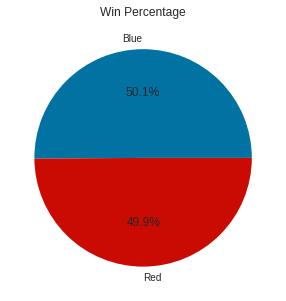

In [10]:
print("Total number of matches: ",df.shape[0])
print(df['blueWins'].replace({0:"Red Win", 1:"Blue Win"}).value_counts())
plt.figure(figsize = (5,5))
plt.pie(df['blueWins'].value_counts(), labels=["Blue", "Red"], colors=["b","r"], autopct="%.01f%%")
plt.title("Win Percentage")
plt.gcf().set_facecolor('white')
plt.show()

### Impact of gold advantage

Gold difference (positive for blue advantage):
Min:  -22551
Max:  21186


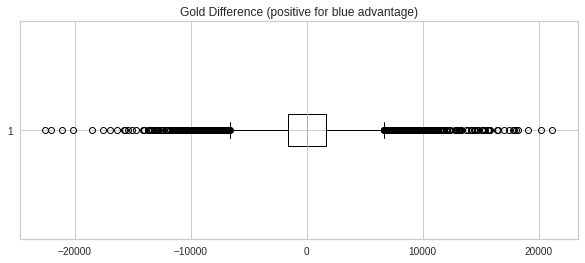

In [11]:
df['goldDiff'] = df['blueTotalGolds'] - df['redTotalGolds']
print("Gold difference (positive for blue advantage):")
print("Min: ",df['goldDiff'].min())
print("Max: ",df['goldDiff'].max())
plt.figure(figsize=(10,4))
plt.title("Gold Difference (positive for blue advantage)")
plt.boxplot(df["goldDiff"], vert=False)
plt.show()

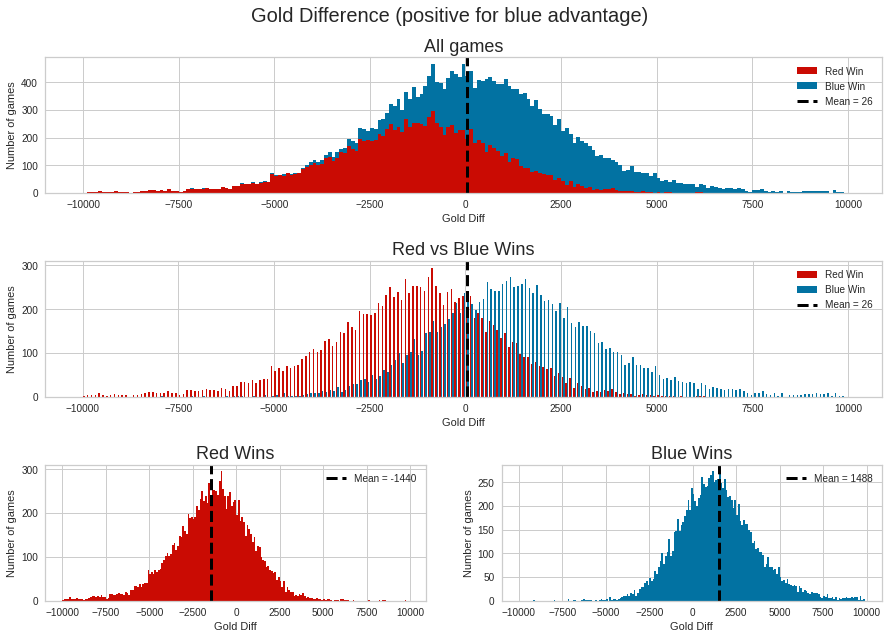

In [12]:
bins = np.arange(-10000,10000,100)
fig = plt.figure(figsize = (15,10))
fig.suptitle("Gold Difference (positive for blue advantage)", fontsize=20, y=0.95)
gs = GridSpec(3, 2, figure=fig)
# All games
ax0 = fig.add_subplot(gs[0, :])
ax0.hist([df[df["blueWins"] == 0]["goldDiff"], df[df["blueWins"] == 1]["goldDiff"]], bins,stacked=True, color=["r","b"], label=["Red Win", "Blue Win"])
ax0.set_title("All games",fontsize=18)
ax0.set_xlabel("Gold Diff")
ax0.set_ylabel("Number of games")
ax0.axvline(df["goldDiff"].mean(), linestyle="--", linewidth=3, color="black", label="Mean = "+str(int(df["goldDiff"].mean())))
ax0.legend()

ax1 = fig.add_subplot(gs[1, :])
ax1.hist([df[df["blueWins"] == 0]["goldDiff"], df[df["blueWins"] == 1]["goldDiff"]], bins, color=["r","b"], label=["Red Win", "Blue Win"])
ax1.set_title("Red vs Blue Wins",fontsize=18)
ax1.set_xlabel("Gold Diff")
ax1.set_ylabel("Number of games")
ax1.axvline(df["goldDiff"].mean(), linestyle="--", linewidth=3, color="black", label="Mean = "+str(int(df["goldDiff"].mean())))
ax1.legend()
# Blue Wins
ax2 = fig.add_subplot(gs[2, 1])
ax2.hist(df[df["blueWins"] == 1]["goldDiff"], bins, color="b")
ax2.set_title("Blue Wins",fontsize=18)
ax2.set_xlabel("Gold Diff")
ax2.set_ylabel("Number of games")
ax2.axvline(df[df["blueWins"] == 1]["goldDiff"].mean(), linestyle="--", linewidth=3, color="black", 
            label="Mean = "+str(int(df[df["blueWins"] == 1]["goldDiff"].mean())))
ax2.legend()
#Red Wins
ax3 = fig.add_subplot(gs[2, 0])
ax3.hist(df[df["blueWins"] == 0]["goldDiff"], bins, color="r")
ax3.set_title("Red Wins",fontsize=18)
ax3.set_xlabel("Gold Diff")
ax3.set_ylabel("Number of games")
ax3.axvline(df[df["blueWins"] == 0]["goldDiff"].mean(), linestyle="--", linewidth=3, color="black", 
            label="Mean = "+str(int(df[df["blueWins"] == 0]["goldDiff"].mean())))
ax3.legend()
plt.subplots_adjust(hspace=0.5)
plt.show()

### Impact of First Inhibitor

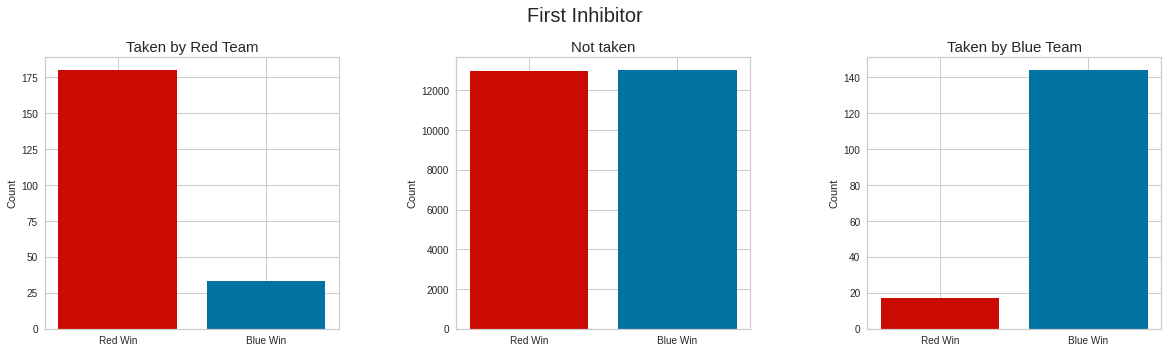

In [13]:
inhib_results = df.groupby(['firstInhibitor'])["blueWins"].value_counts().sort_index()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("First Inhibitor", fontsize=20, y = 1.02)
plt.subplots_adjust(wspace=0.4)

axes[0].bar(["Red Win", "Blue Win"], inhib_results[-1], color=["r","b"])
axes[0].set_title('Taken by Red Team',fontsize=15)
axes[0].set_ylabel('Count')

axes[1].bar(["Red Win", "Blue Win"], inhib_results[0], color=["r","b"])
axes[1].set_title('Not taken',fontsize=15)
axes[1].set_ylabel('Count')

axes[2].bar(["Red Win", "Blue Win"], inhib_results[1], color=["r","b"])
axes[2].set_title('Taken by Blue Team',fontsize=15)
axes[2].set_ylabel('Count')
plt.show()

In [14]:
df.corr()['blueWins'][:-1].sort_values()

redDragon              -0.207422
redKill                -0.195216
redTotalMinionKills    -0.155927
redTotalGolds          -0.125910
redAssist              -0.114068
redTowerKills          -0.105219
redAvgLevel            -0.100695
firstInhibitor          0.087321
blueTowerKills          0.113657
blueAvgLevel            0.127230
riftHerald              0.133327
blueAssist              0.136103
blueTotalMinionKills    0.139582
blueTotalGolds          0.140681
firstTower              0.159770
blueDragon              0.202898
blueKill                0.212145
blueWins                1.000000
Name: blueWins, dtype: float64

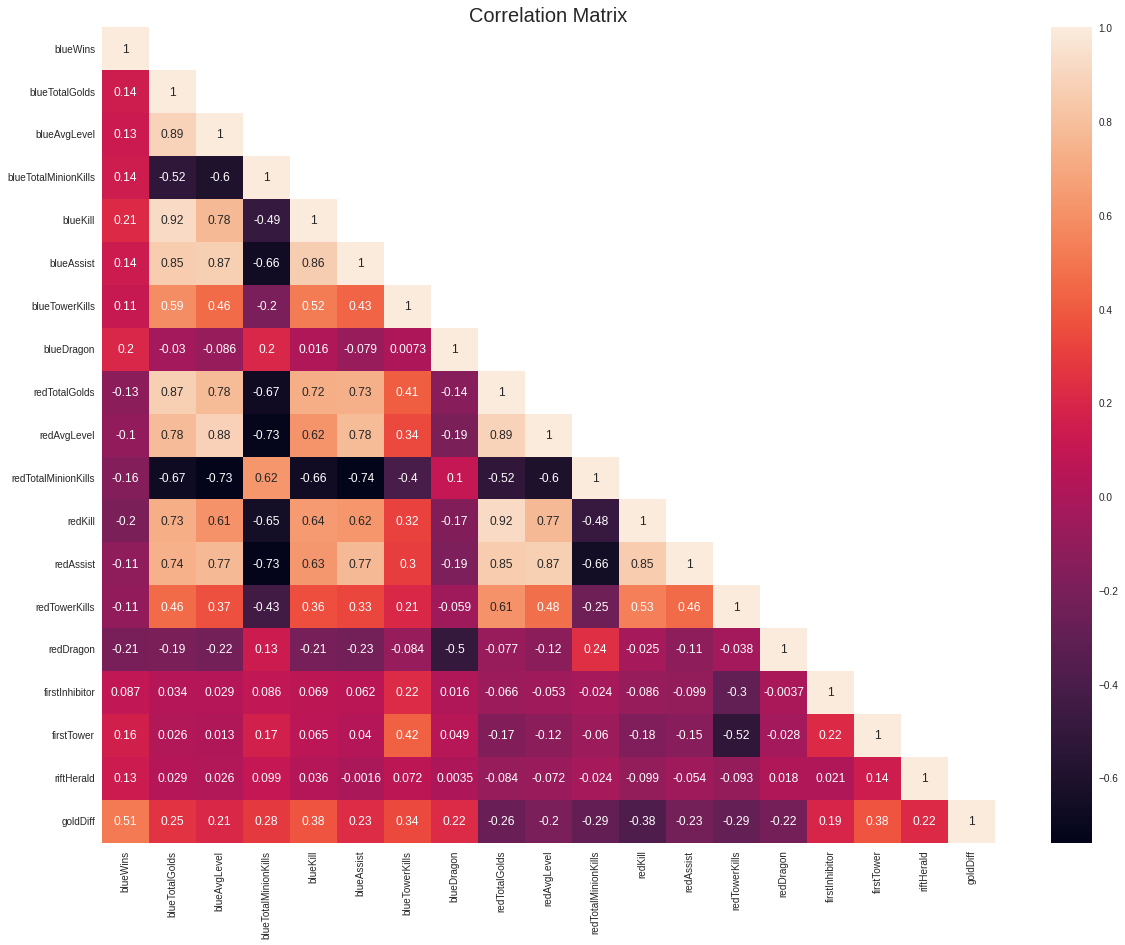

In [15]:
plt.figure(figsize = (20,15))
corr= df.corr()
# Getting the Upper Triangle of the correlation matrix
mask = np.triu(corr,1)
sns.heatmap(corr,annot = True, mask = mask)
plt.title("Correlation Matrix", fontsize=20)
plt.show()

An interesting observation is that the amount of minions killed by the blue team has some degree of negative correlation with all PVP statistics (kills, assists), and a positive one with all PVE statistics (Dragons, Heralds, towers, inhibitors). The observation holds true for minions killed by the red team as well. This suggest that a high value for minions killed by either team is indicative of a passive game, with both teams playing for objective control, while a low number points to a more aggresive match, with many skirmishes and teamfights, which would also lead to higher gold and average level numbers.  
Most importantly however, a minion advantage has a slight positive correlation with winning the game, so it should be encouraged, especially when kills and assists aren't available.

## Statistical Analysis Experiments: 

A quick look at the Summoner's Rift map will tell you that the Dragon's spawn point is easier to access from the red side, while the Rift Herald's location favours the blue team.  
With this in mind, I am interested in answering 2 questions:
 1. Are Dragons more likely to be taken by the red team?
 2. Are Rift Heralds more likely to be taken by the blue team?  

I will perform a One Proportion Z-Test to find out whether there is a statistically significant difference between the 2 teams for each case, with 95% confidence.

Total number of Dragons:  17938
Blue:  8104
Red:  9834


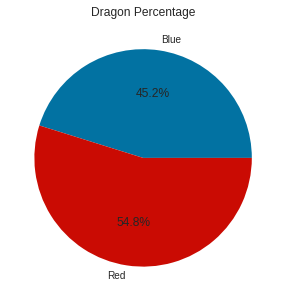

In [16]:
redDragons = df["redDragon"].sum()
blueDragons = df["blueDragon"].sum()
totalDragons = redDragons + blueDragons

print("Total number of Dragons: ",totalDragons)
print("Blue: ", blueDragons)
print("Red: ", redDragons)

plt.figure(figsize = (5,5))
plt.pie([blueDragons, redDragons], labels=["Blue", "Red"], colors=["b","r"], autopct="%.01f%%")
plt.title("Dragon Percentage")
plt.gcf().set_facecolor('white')
plt.show()

If neither team is more likely to slay Dragons, then the proportion taken by the red team should be 50%. I will perform an upper-tailed one proportion Z test to find out if the percentage is statistically significantly higher than 50%, with 95% confidence.  
$H_0$: $p = p_0$  
$H_a$: $p > p_0$  
Confidence level: 95% $\implies$ Alpha level: $\alpha$ = 0.05



Notation:  
p = percentage of Dragons taken by the red team  
$p_0$ = 0.5

In [17]:
# Dragons Test
# Are Dragons more likely to be taken by the red team?
(z,p) = proportions_ztest(count=redDragons, nobs=totalDragons, value=0.5, alternative = "larger")
print("p-value = ", p)

p-value =  8.21634941153371e-39


### Conclusion: Since p < 0.05, we can reject the null hypothesis. Therefore, we can claim with 95% confidence that the red team is more likely to get Dragons than the blue team at the 10 minute mark.

Total number of Rift Heralds:  8583
Blue:  5009
Red:  3574


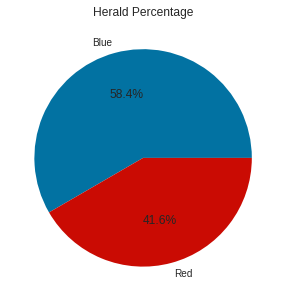

In [18]:
heralds = df['riftHerald'].replace({-1:"Red", 1:"Blue"}).value_counts()
redHeralds = heralds["Red"]
blueHeralds =heralds["Blue"]
totalHeralds = redHeralds + blueHeralds

print("Total number of Rift Heralds: ",totalHeralds)
print("Blue: ", blueHeralds)
print("Red: ", redHeralds)

plt.figure(figsize = (5,5))
plt.pie([blueHeralds, redHeralds], labels=["Blue", "Red"], colors=["b","r"], autopct="%.01f%%")
plt.title("Herald Percentage")
plt.gcf().set_facecolor('white')
plt.show()

If neither team is more likely to slay Rift Heralds, then the proportion taken by the blue team should be 50%. I will perform an upper-tailed one proportion Z test to find out if the percentage is statistically significantly higher than 50%, with 95% confidence.  
$H_0$: $p = p_0$  
$H_a$: $p > p_0$  
Confidence level: 95% $\implies$ Alpha level: $\alpha$ = 0.05



Notation:  
p = percentage of Rift Heralds taken by the blue team  
$p_0$ = 0.5

In [19]:
# Rift Heralds Test
# Are Heralds more likely to be taken by the blue team?
(z,p) = proportions_ztest(count=blueHeralds, nobs=totalHeralds, value=0.5, alternative = "larger")
print("p-value = ", p)

p-value =  6.4131008717997e-56


### Conclusion: Since p < 0.05, we can reject the null hypothesis. Therefore, we can claim with 95% confidence that the blue team is more likely to get Rift Heralds than the red team at the 10 minute mark.

# 2. Building the Models

In League of Legends, the game client does not have access to all of the current match's information, with the most notable omission being each team's total gold, which is arguably the most important factor for determining who is currently in an advantageous position.  
I will build, train and test a model using only client-accessible data, and one which also includes the gold values stored by the server.  
The former can be used by a third party application for an in-game overlay, as it fits the guidelines enforced by Riot Games, while the latter would prove useful during the live broadcasts of Esports events.  
For this task, I will use a logistic regression model created using Sklearn, as it provides a win probability value for each output prediction.

In [20]:
df['minionDiff'] = df['blueTotalMinionKills'] - df['redTotalMinionKills']
df['avgLevelDiff'] = df['blueAvgLevel'] - df['redAvgLevel']
df['towerKillDiff'] = df['blueTowerKills'] - df['redTowerKills']
df['dragonDiff'] = df['blueDragon'] - df['redDragon']
df['killDiff'] = df['blueKill'] - df['redKill']
df['assistDiff'] = df['blueAssist'] - df['redAssist']

In [21]:
# Feature Selection
x_cols1 = ['minionDiff','avgLevelDiff','killDiff', 'assistDiff','towerKillDiff','firstInhibitor','dragonDiff','riftHerald']
x_cols2 = ['goldDiff','avgLevelDiff','dragonDiff']

x1 = df[x_cols1]
x1 = StandardScaler().fit(x1).transform(x1.astype(float))
y1 = df['blueWins']


x2 = df[x_cols2]
x2 = StandardScaler().fit(x2).transform(x2.astype(float))
y2 = df['blueWins']

In [22]:
# Data splitting
x1_train,x1_test,y1_train,y1_test=train_test_split(x1,y1,test_size=0.20,random_state=1)
x2_train,x2_test,y2_train,y2_test=train_test_split(x2,y2,test_size=0.20,random_state=1)

logreg1 = LogisticRegression()
logreg2 = LogisticRegression()
# Training the models
logreg1.fit(x1_train,y1_train)
logreg2.fit(x2_train,y2_train)
# Testing the models
y1_pred=logreg1.predict(x1_test)
y2_pred=logreg2.predict(x2_test)

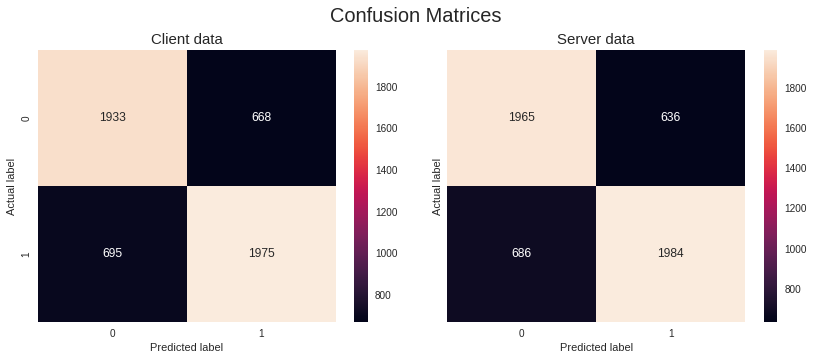

+------------+--------+--------+------------+
|            | Client | Server | Difference |
+------------+--------+--------+------------+
| Accuracy:  | 0.7414 | 0.7492 |   0.0078   |
| Precision: | 0.7473 | 0.7573 |    0.01    |
|  Recall:   | 0.7397 | 0.7431 |   0.0034   |
| F1 Score:  | 0.7435 | 0.7501 |   0.0066   |
+------------+--------+--------+------------+


In [23]:
# Constructing the Confusion Matrices
cnf_matrix1 = metrics.confusion_matrix(y1_test, y1_pred)
cnf_matrix2 = metrics.confusion_matrix(y2_test, y2_pred)


fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
fig.suptitle("Confusion Matrices", fontsize=20, y=1)
plt.subplots_adjust(wspace=0.1)
# Client Data
sns.heatmap(ax= axes[0], data = pd.DataFrame(cnf_matrix1), annot=True, fmt='g')
axes[0].set_title('Client data',fontsize=15)
axes[0].set_ylabel('Actual label')
axes[0].set_xlabel('Predicted label')
# Server Data
sns.heatmap(ax= axes[1], data = pd.DataFrame(cnf_matrix2), annot=True,fmt='g')
axes[1].set_title('Server data',fontsize=15)
axes[1].set_ylabel('Actual label')
axes[1].set_xlabel('Predicted label')
plt.show()

from prettytable import PrettyTable
t = PrettyTable(['','Client', 'Server', "Difference"])
acc1 = round(metrics.accuracy_score(y1_test, y1_pred), 4)
acc2 =  round(metrics.accuracy_score(y2_test, y2_pred),4)
t.add_row(['Accuracy:', acc1, acc2, round(acc2 - acc1,4)])
prec1 = round(metrics.precision_score(y1_test, y1_pred), 4)
prec2 =  round(metrics.precision_score(y2_test, y2_pred),4)
t.add_row(['Precision:', prec1, prec2, round(prec2 - prec1,4)])
recall1 = round(metrics.recall_score(y1_test, y1_pred), 4)
recall2 =  round(metrics.recall_score(y2_test, y2_pred),4)
t.add_row(['Recall:', recall1, recall2, round(recall2 - recall1,4)])
f1score_1 = round(metrics.f1_score(y1_test, y1_pred), 4)
f1score_2 =  round(metrics.f1_score(y2_test, y2_pred),4)
t.add_row(['F1 Score:', f1score_1, f1score_2, round(f1score_2 - f1score_1,4)])
print(t)

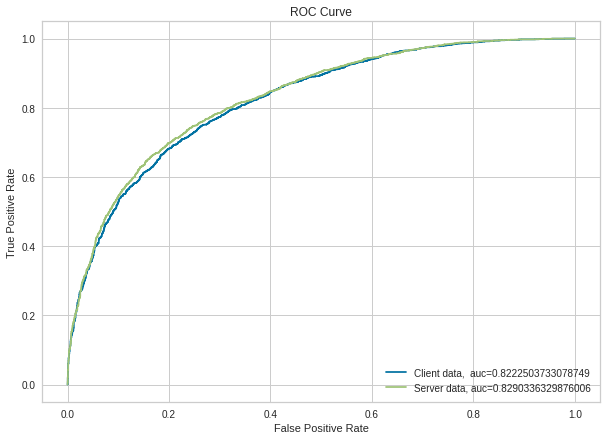

In [24]:
y1_pred_proba = logreg1.predict_proba(x1_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y1_test,  y1_pred_proba)
auc1 = metrics.roc_auc_score(y1_test, y1_pred_proba)

y2_pred_proba = logreg2.predict_proba(x2_test)[::,1]
fpr2, tpr2, _ = metrics.roc_curve(y2_test,  y2_pred_proba)
auc2 = metrics.roc_auc_score(y2_test, y2_pred_proba)

# Plotting the ROC Curves
plt.figure(figsize = (10,7))
plt.plot(fpr1,tpr1,label="Client data,  auc="+str(auc1))
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")

plt.plot(fpr2,tpr2,label="Server data, auc="+str(auc2))
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)
plt.show()

The greater the Area Under Curve, the better predictive ability of the model.  
Since AUC > 0.8, the predictors can be considered good to very good.

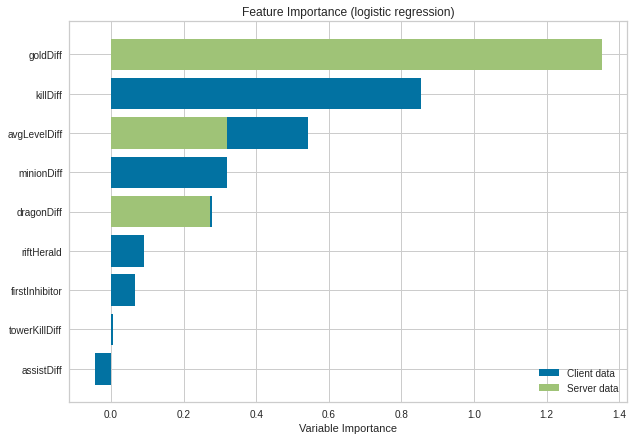

In [25]:
# Get importance
feat_coef1 = logreg1.coef_[0]
sorted_coef1 = sorted(zip(x_cols1, feat_coef1),key = lambda x: x[1])
cols1, coefs1 = zip(*sorted_coef1)
feat_coef2 = logreg2.coef_[0]
sorted_coef2 = sorted(zip(x_cols2, feat_coef2),key = lambda x: x[1])
cols2, coefs2 = zip(*sorted_coef2)
    
# Plot feature importance
plt.figure(figsize = (10,7))
plt.title("Feature Importance (logistic regression)")
plt.xlabel("Variable Importance")
plt.barh(cols1, coefs1, label="Client data")
plt.barh(cols2, coefs2, label="Server data")
plt.legend()
plt.show()

 - Client data : kill, average level, minion and dragon differences are the most important features in this model.
 - Server data : gold difference is by far the most important feature

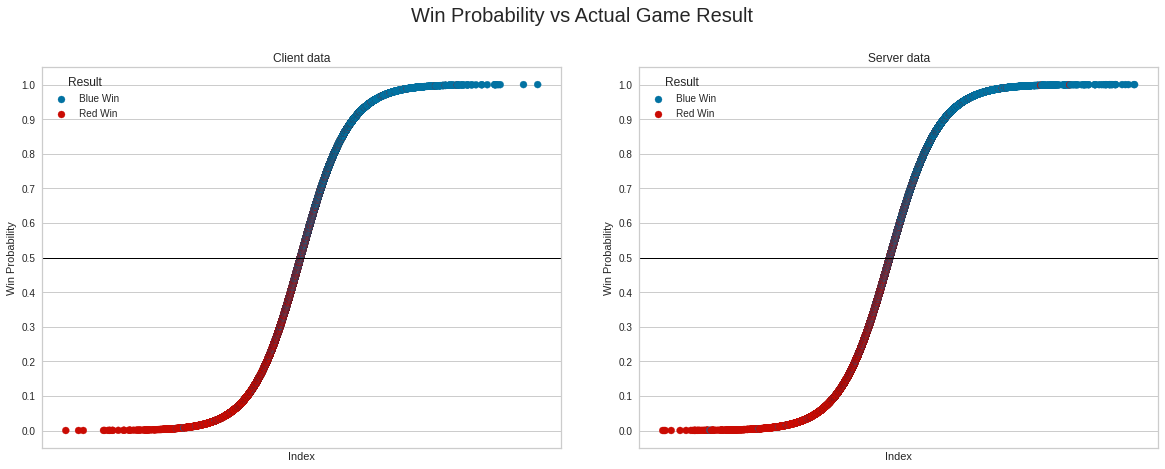

In [26]:
import math
def rev_sigmoid(x):
    return -math.log((1 / x) - 1)
rev_sigm = np.vectorize(rev_sigmoid)

# Get win probabilities
y1_pred_proba = logreg1.predict_proba(x1)[::,1]
df["blueWinsProb1"] = y1_pred_proba
df_client = df.sort_values(by=["blueWinsProb1"])

y2_pred_proba = logreg2.predict_proba(x2)[::,1]
df["blueWinsProb2"] = y2_pred_proba
df_server = df.sort_values(by=["blueWinsProb2"])


df_client["rev_sigm"] = rev_sigm(df_client['blueWinsProb1'])
df_client = df_client[(df_client["rev_sigm"] < 10) & (df_client["rev_sigm"] > -10)]

df_server["rev_sigm"] = rev_sigm(df_server['blueWinsProb2'])
df_server = df_server[(df_server["rev_sigm"] < 10) & (df_server["rev_sigm"] > -10)]

fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Win Probability vs Actual Game Result", fontsize=20, y=1)
plt.subplots_adjust(wspace=0.15)

axes[0].scatter([], [], color="b")
axes[0].scatter([], [], color="r")
axes[0].scatter(df_client["rev_sigm"], df_client["blueWinsProb1"], color=np.where(df_client["blueWins"] == 1, 'b', 'r'))
axes[0].set_title("Client data")
axes[0].set_ylabel("Win Probability")
axes[0].set_xlabel("Index")
axes[0].set_xticks([])
axes[0].set_yticks(np.arange(0,1.1,0.1))
axes[0].axhline(0.5, linestyle="-", linewidth=1, color="black")
axes[0].legend(labels=["Blue Win","Red Win"],title="Result")

axes[1].scatter([], [], color="b")
axes[1].scatter([], [], color="r")
axes[1].scatter(df_server["rev_sigm"], df_server["blueWinsProb2"], color=np.where(df_server["blueWins"] == 1, 'b', 'r'))
axes[1].set_title("Server data")
axes[1].set_ylabel("Win Probability")
axes[1].set_xlabel("Index")
axes[1].set_xticks([])
axes[1].set_yticks(np.arange(0,1.1,0.1))
axes[1].axhline(0.5, linestyle="-", linewidth=1, color="black")
axes[1].legend(labels=["Blue Win","Red Win"],title="Result")
plt.show()

As many blue dots should place above the 0.5 line, while the red ones should be found under it, meaning that the prediction was accurate.  
We can notice that the games with win percentage values around 0.5 are the most likely to have been incorrectly predicted, which is to be expected in a game as complex as League of Legends, accounting for its multiple comeback mechanics, the human players' mistakes and different team compositions.

## Client vs Server Conclusion
Both of the models perform similarly on this task, with the model using the server data having a slightly better performance across the board.  
The client data model performs surprisingly well despite not having access to all of the game data, which could be because the total gold number for each team can be approximated well enough using the kills, assists, minions and towers taken values.  
Therefore, both of these predictors can already be useful for enhancing a player's or watcher's understanding of the state of the game at the 10 minute mark. 

# 3. Comparing other types of ML models

Both of the classifiers above are logistic regression models. To quickly test and compare other different ML models on this classification task I will be using the PyCaret library.  
I will only use the data available to the game client during the match, as this would be the more likely use case for such a model, being implemented in some approved third party software.

## Random Forest Classifier for Feature Importance
One of the most popular methods for calculating feature importance is by using a Random Forest Classifier.  
Tree-based models do have a tendency to overevaluate the importance of continuous features, while assigning lower values to discrete, low cardinality features (e.g firstInhibitor, riftHerald, dragonDiff), but they do give a rough idea of the relative importance of each feature in the training data.

In [27]:
x_cols = ['minionDiff','avgLevelDiff','killDiff', 'assistDiff','towerKillDiff','firstInhibitor','dragonDiff','riftHerald']

x = df[x_cols]
y = df['blueWins']

In [28]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(x,y)

RandomForestClassifier(random_state=0)

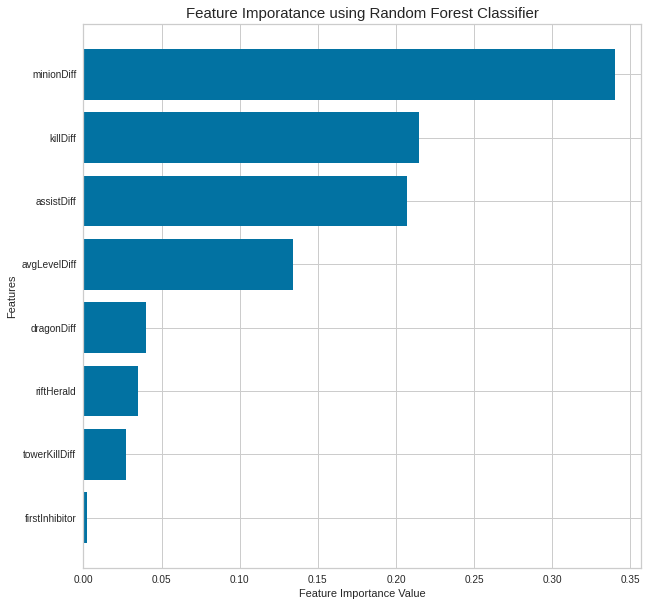

In [29]:
plt.figure(figsize=(10,10))

data = pd.DataFrame(data = rfc.feature_importances_, index = x_cols, columns=["feat_imp"]).sort_values("feat_imp")
plt.barh(data.index, data["feat_imp"])
plt.title("Feature Imporatance using Random Forest Classifier", fontsize=15)
plt.ylabel("Features")
plt.xlabel('Feature Importance Value')
plt.show()

Unsurprisingly, gold generating actions (getting minions, kills, assists) are the most predictive of the game's outcome.

## Model building using PyCaret

In [30]:
# Separating features into numerical and categorical features
feat_cat=[]
feat_num=[]
for col in list(x_cols):
    if(len(x[col].unique())<=30):
        feat_cat.append(col)
    else:
        feat_num.append(col)
print("Categorical features: " , feat_cat)
print("Numerical features: ", feat_num)
x["blueWins"] = y

Categorical features:  ['towerKillDiff', 'firstInhibitor', 'dragonDiff', 'riftHerald']
Numerical features:  ['minionDiff', 'avgLevelDiff', 'killDiff', 'assistDiff']


In [31]:
models=setup(data=x,
             categorical_features=feat_cat,
             target="blueWins",
             silent=True,
             session_id=2402)

,Description,Value
0,session_id,2402
1,Target,blueWins
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(26354, 9)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,4
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
model_results=compare_models()
print(model_results)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7361,0.8164,0.7356,0.7349,0.7351,0.4722,0.4723,0.7160
gbc,Gradient Boosting Classifier,0.7361,0.8160,0.7302,0.7374,0.7337,0.4721,0.4722,1.3000
ada,Ada Boost Classifier,0.7351,0.8145,0.7304,0.7359,0.7330,0.4701,0.4702,0.4780
ridge,Ridge Classifier,0.7347,0.0000,0.7321,0.7344,0.7332,0.4694,0.4695,0.0440
lda,Linear Discriminant Analysis,0.7344,0.8154,0.7318,0.7342,0.7329,0.4688,0.4690,0.0820
lightgbm,Light Gradient Boosting Machine,0.7333,0.8127,0.7270,0.7350,0.7308,0.4667,0.4668,0.1950
rf,Random Forest Classifier,0.7021,0.7760,0.6981,0.7022,0.7001,0.4042,0.4043,1.3530
knn,K Neighbors Classifier,0.6976,0.7561,0.6982,0.6957,0.6969,0.3952,0.3953,0.3140
svm,SVM - Linear Kernel,0.6946,0.0000,0.6913,0.6945,0.6926,0.3893,0.3896,0.3470
et,Extra Trees Classifier,0.6946,0.7575,0.6901,0.6950,0.6924,0.3893,0.3895,1.5590


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2402, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


The best performing models seem to be the Logistic Regression and Gradient Boosting Classifier.  
Since I have already built and analysed a LogReg model in this Jupyter Notebook, I will explore the Gradient Boosting model now.

## Gradient Boosting Classifier

In [33]:
gbc_model =  create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7415,0.8201,0.7516,0.7348,0.7431,0.4830,0.4831
1,0.7339,0.8059,0.7095,0.7443,0.7265,0.4676,0.4682
2,0.7257,0.8077,0.7214,0.7262,0.7238,0.4515,0.4515
3,0.7344,0.8160,0.7236,0.7381,0.7308,0.4688,0.4689
4,0.7404,0.8247,0.7236,0.7472,0.7352,0.4807,0.4809
5,0.7393,0.8155,0.7334,0.7407,0.7370,0.4786,0.4786
6,0.7306,0.8214,0.7182,0.7350,0.7265,0.4612,0.4613
7,0.7191,0.8014,0.7342,0.7110,0.7224,0.4382,0.4385
8,0.7451,0.8213,0.7397,0.7462,0.7429,0.4902,0.4902


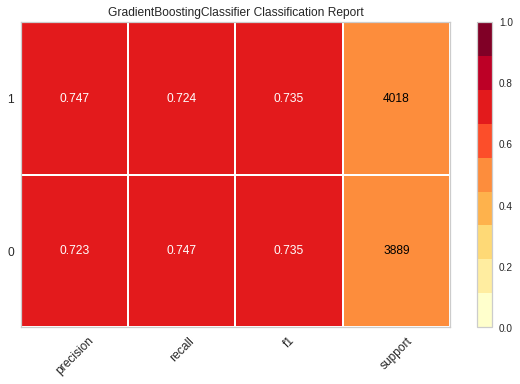

In [34]:
plot_model(estimator=gbc_model,plot='class_report')

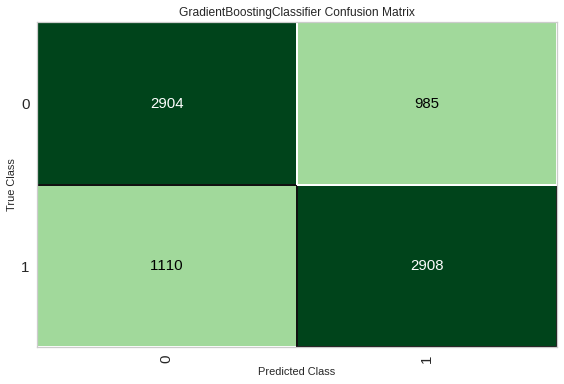

In [35]:
plot_model(estimator=gbc_model,plot='confusion_matrix')

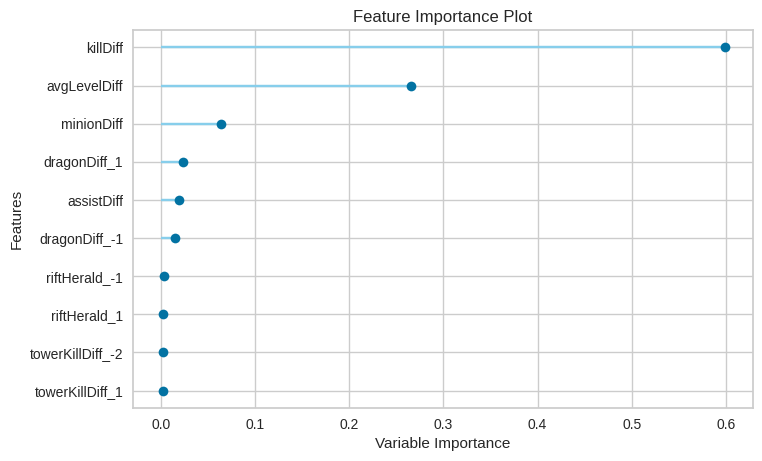

In [36]:
plot_model(estimator=gbc_model,plot='feature')

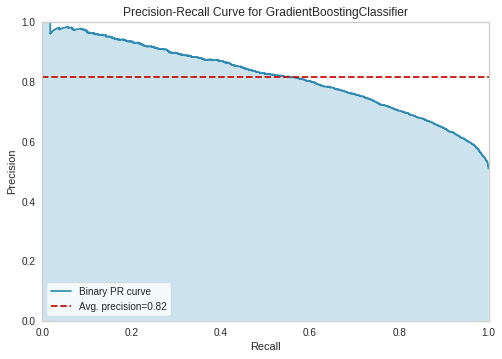

In [37]:
plot_model(estimator=gbc_model,plot='pr')

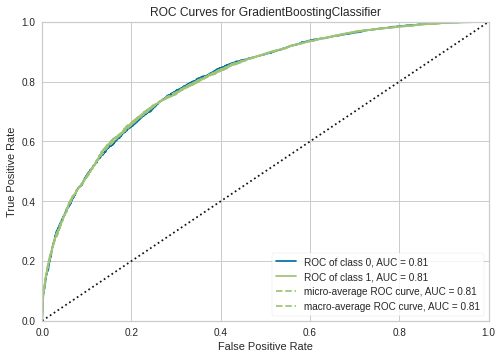

In [38]:
plot_model(gbc_model)

# Conclusion
1. I have explored the game dataset, highlighting basic trends through plots and graphs, and statistically proved with 95% confidence that the Red team is more likely to take dragons, while the Blue team tends to slays more Rift Heralds.
2. I have built and compared 2 Logistic Regression models that predict the win probabilities of each team after 10 minutes of game time with 74-75% accuracy:
    - The first model only uses the data available to the game client, and could be implemented in downloadable third party software.
    - The second model uses the data stored by the game server, and could be used during the live broadcast of Esports events.
3. I have run a comparison of multiple types of ML models on this task. The best performing model remains the Logistic Regression one, so I briefly evaluated one of the runner-ups, the Gradient Boosting Classifier.